In What 🤗 Transformers can do, you learned about natural language processing (NLP), speech and audio, computer vision tasks, and some important applications of them. This page will look closely at how models solve these tasks and explain what’s happening under the hood. There are many ways to solve a given task, some models may implement certain techniques or even approach the task from a new angle, but for Transformer models, the general idea is the same. Owing to its flexible architecture, most models are a variant of an encoder, decoder, or encoder-decoder structure. In addition to Transformer models, our library also has several convolutional neural networks (CNNs), which are still used today for computer vision tasks. We’ll also explain how a modern CNN works.

To explain how tasks are solved, we’ll walk through what goes on inside the model to output useful predictions.

Wav2Vec2 for audio classification and automatic speech recognition (ASR)
Vision Transformer (ViT) and ConvNeXT for image classification
DETR for object detection
Mask2Former for image segmentation
GLPN for depth estimation
BERT for NLP tasks like text classification, token classification and question answering that use an encoder
GPT2 for NLP tasks like text generation that use a decoder
BART for NLP tasks like summarization and translation that use an encoder-decoder

Before you go further, it is good to have some basic knowledge of the original Transformer architecture. Knowing how encoders, decoders, and attention work will aid you in understanding how different Transformer models work. If you’re just getting started or need a refresher, check out our course for more information!
Speech and audio

Wav2Vec2 is a self-supervised model pretrained on unlabeled speech data and finetuned on labeled data for audio classification and automatic speech recognition.


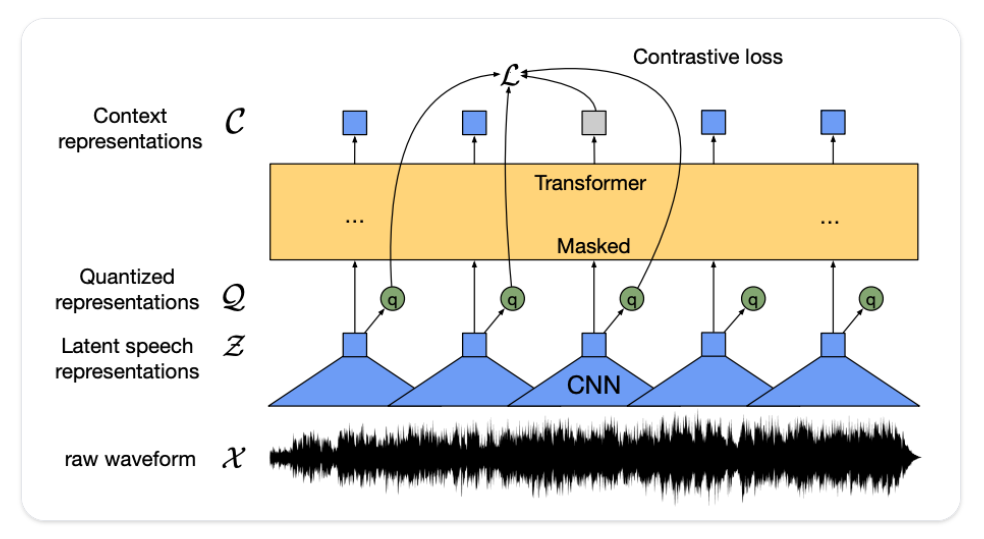

This model has four main components:

    A feature encoder takes the raw audio waveform, normalizes it to zero mean and unit variance, and converts it into a sequence of feature vectors that are each 20ms long.

    Waveforms are continuous by nature, so they can’t be divided into separate units like a sequence of text can be split into words. That’s why the feature vectors are passed to a quantization module, which aims to learn discrete speech units. The speech unit is chosen from a collection of codewords, known as a codebook (you can think of this as the vocabulary). From the codebook, the vector or speech unit, that best represents the continuous audio input is chosen and forwarded through the model.

    About half of the feature vectors are randomly masked, and the masked feature vector is fed to a context network, which is a Transformer encoder that also adds relative positional embeddings.

    The pretraining objective of the context network is a contrastive task. The model has to predict the true quantized speech representation of the masked prediction from a set of false ones, encouraging the model to find the most similar context vector and quantized speech unit (the target label).

Now that wav2vec2 is pretrained, you can finetune it on your data for audio classification or automatic speech recognition!
Audio classification

To use the pretrained model for audio classification, add a sequence classification head on top of the base Wav2Vec2 model. The classification head is a linear layer that accepts the encoder’s hidden states. The hidden states represent the learned features from each audio frame which can have varying lengths. To create one vector of fixed-length, the hidden states are pooled first and then transformed into logits over the class labels. The cross-entropy loss is calculated between the logits and target to find the most likely class.

Ready to try your hand at audio classification? Check out our complete audio classification guide to learn how to finetune Wav2Vec2 and use it for inference!
Automatic speech recognition

To use the pretrained model for automatic speech recognition, add a language modeling head on top of the base Wav2Vec2 model for connectionist temporal classification (CTC). The language modeling head is a linear layer that accepts the encoder’s hidden states and transforms them into logits. Each logit represents a token class (the number of tokens comes from the task vocabulary). The CTC loss is calculated between the logits and targets to find the most likely sequence of tokens, which are then decoded into a transcription.

Ready to try your hand at automatic speech recognition? Check out our complete automatic speech recognition guide to learn how to finetune Wav2Vec2 and use it for inference!
Computer vision

There are two ways to approach computer vision tasks:

Split an image into a sequence of patches and process them in parallel with a Transformer.
Use a modern CNN, like ConvNeXT, which relies on convolutional layers but adopts modern network designs.

A third approach mixes Transformers with convolutions (for example, Convolutional Vision Transformer or LeViT). We won’t discuss those because they just combine the two approaches we examine here.

ViT and ConvNeXT are commonly used for image classification, but for other vision tasks like object detection, segmentation, and depth estimation, we’ll look at DETR, Mask2Former and GLPN, respectively; these models are better suited for those tasks.
Image classification

ViT and ConvNeXT can both be used for image classification; the main difference is that ViT uses an attention mechanism while ConvNeXT uses convolutions.
Transformer

ViT replaces convolutions entirely with a pure Transformer architecture. If you’re familiar with the original Transformer, then you’re already most of the way toward understanding ViT.

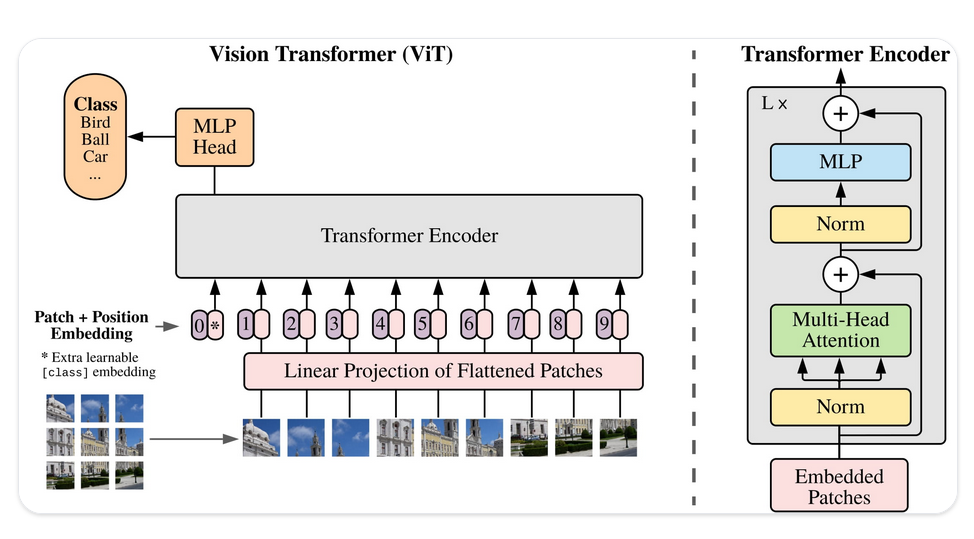

The main change ViT introduced was in how images are fed to a Transformer:

An image is split into square non-overlapping patches, each of which gets turned into a vector or patch embedding. The patch embeddings are generated from a convolutional 2D layer which creates the proper input dimensions (which for a base Transformer is 768 values for each patch embedding). If you had a 224x224 pixel image, you could split it into 196 16x16 image patches. Just like how text is tokenized into words, an image is “tokenized” into a sequence of patches.

A learnable embedding - a special [CLS] token - is added to the beginning of the patch embeddings just like BERT. The final hidden state of the [CLS] token is used as the input to the attached classification head; other outputs are ignored. This token helps the model learn how to encode a representation of the image.

The last thing to add to the patch and learnable embeddings are the position embeddings because the model doesn’t know how the image patches are ordered. The position embeddings are also learnable and have the same size as the patch embeddings. Finally, all of the embeddings are passed to the Transformer encoder.

The output, specifically only the output with the [CLS] token, is passed to a multilayer perceptron head (MLP). ViT’s pretraining objective is simply classification. Like other classification heads, the MLP head converts the output into logits over the class labels and calculates the cross-entropy loss to find the most likely class.

Ready to try your hand at image classification? Check out our complete image classification guide to learn how to finetune ViT and use it for inference!
CNN

This section briefly explains convolutions, but it’d be helpful to have a prior understanding of how they change an image’s shape and size. If you’re unfamiliar with convolutions, check out the Convolution Neural Networks chapter from the fastai book!

ConvNeXT is a CNN architecture that adopts new and modern network designs to improve performance. However, convolutions are still at the core of the model. From a high-level perspective, a convolution is an operation where a smaller matrix (kernel) is multiplied by a small window of the image pixels. It computes some features from it, such as a particular texture or curvature of a line. Then it slides over to the next window of pixels; the distance the convolution travels is known as the stride.

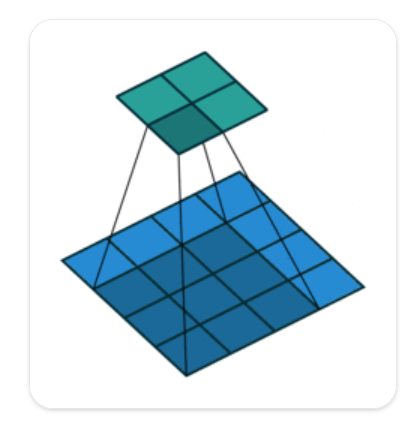

A basic convolution without padding or stride, taken from A guide to convolution arithmetic for deep learning.

You can feed this output to another convolutional layer, and with each successive layer, the network learns more complex and abstract things like hotdogs or rockets. Between convolutional layers, it is common to add a pooling layer to reduce dimensionality and make the model more robust to variations of a feature’s position.

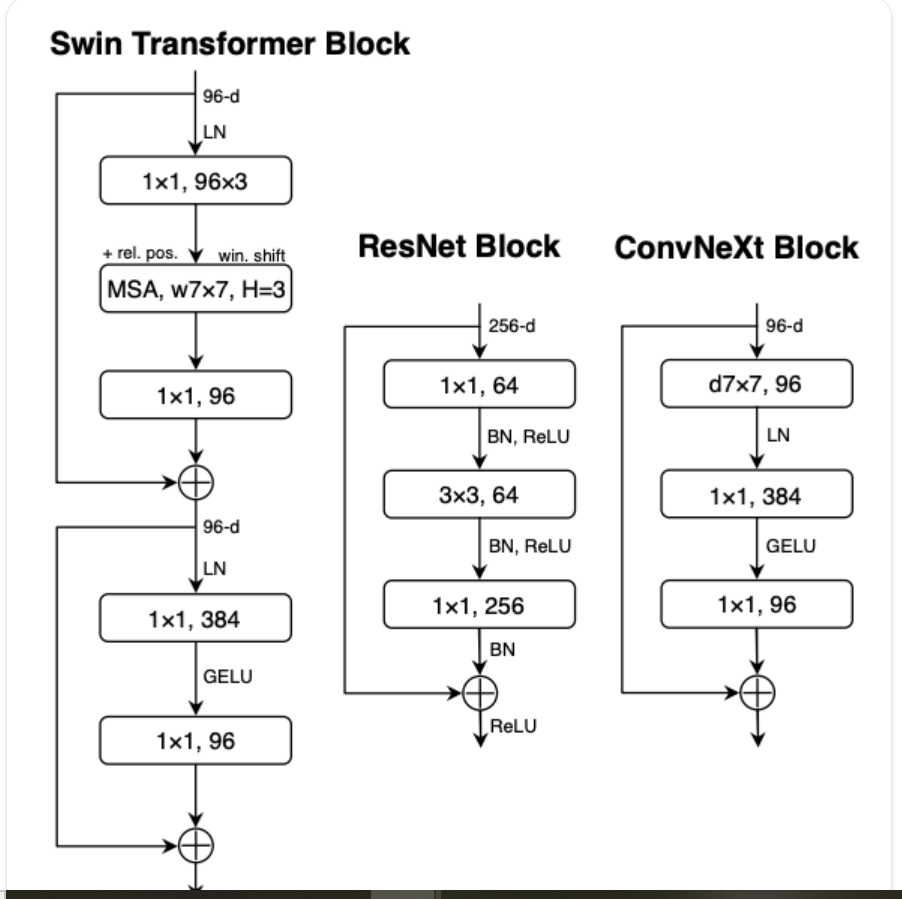

ConvNeXT modernizes a CNN in five ways:

Change the number of blocks in each stage and “patchify” an image with a larger stride and corresponding kernel size. The non-overlapping sliding window makes this patchifying strategy similar to how ViT splits an image into patches.

A bottleneck layer shrinks the number of channels and then restores it because it is faster to do a 1x1 convolution, and you can increase the depth. An inverted bottleneck does the opposite by expanding the number of channels and shrinking them, which is more memory efficient.

Replace the typical 3x3 convolutional layer in the bottleneck layer with depthwise convolution, which applies a convolution to each input channel separately and then stacks them back together at the end. This widens the network width for improved performance.

ViT has a global receptive field which means it can see more of an image at once thanks to its attention mechanism. ConvNeXT attempts to replicate this effect by increasing the kernel size to 7x7.

ConvNeXT also makes several layer design changes that imitate Transformer models. There are fewer activation and normalization layers, the activation function is switched to GELU instead of ReLU, and it uses LayerNorm instead of BatchNorm.

The output from the convolution blocks is passed to a classification head which converts the outputs into logits and calculates the cross-entropy loss to find the most likely label.

Object detection

DETR, DEtection TRansformer, is an end-to-end object detection model that combines a CNN with a Transformer encoder-decoder.

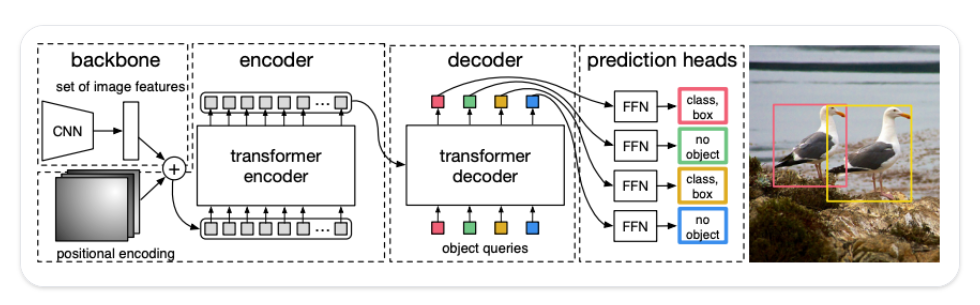

A pretrained CNN backbone takes an image, represented by its pixel values, and creates a low-resolution feature map of it. A 1x1 convolution is applied to the feature map to reduce dimensionality and it creates a new feature map with a high-level image representation. Since the Transformer is a sequential model, the feature map is flattened into a sequence of feature vectors that are combined with positional embeddings.

The feature vectors are passed to the encoder, which learns the image representations using its attention layers. Next, the encoder hidden states are combined with object queries in the decoder. Object queries are learned embeddings that focus on the different regions of an image, and they’re updated as they progress through each attention layer. The decoder hidden states are passed to a feedforward network that predicts the bounding box coordinates and class label for each object query, or no object if there isn’t one.

DETR decodes each object query in parallel to output N final predictions, where N is the number of queries. Unlike a typical autoregressive model that predicts one element at a time, object detection is a set prediction task (bounding box, class label) that makes N predictions in a single pass.

DETR uses a bipartite matching loss during training to compare a fixed number of predictions with a fixed set of ground truth labels. If there are fewer ground truth labels in the set of N labels, then they’re padded with a no object class. This loss function encourages DETR to find a one-to-one assignment between the predictions and ground truth labels. If either the bounding boxes or class labels aren’t correct, a loss is incurred. Likewise, if DETR predicts an object that doesn’t exist, it is penalized. This encourages DETR to find other objects in an image instead of focusing on one really prominent object.

An object detection head is added on top of DETR to find the class label and the coordinates of the bounding box. There are two components to the object detection head: a linear layer to transform the decoder hidden states into logits over the class labels, and a MLP to predict the bounding box.

Ready to try your hand at object detection? Check out our complete object detection guide to learn how to finetune DETR and use it for inference!
Image segmentation

Mask2Former is a universal architecture for solving all types of image segmentation tasks. Traditional segmentation models are typically tailored towards a particular subtask of image segmentation, like instance, semantic or panoptic segmentation. Mask2Former frames each of those tasks as a mask classification problem. Mask classification groups pixels into N segments, and predicts N masks and their corresponding class label for a given image. We’ll explain how Mask2Former works in this section, and then you can try finetuning SegFormer at the end.

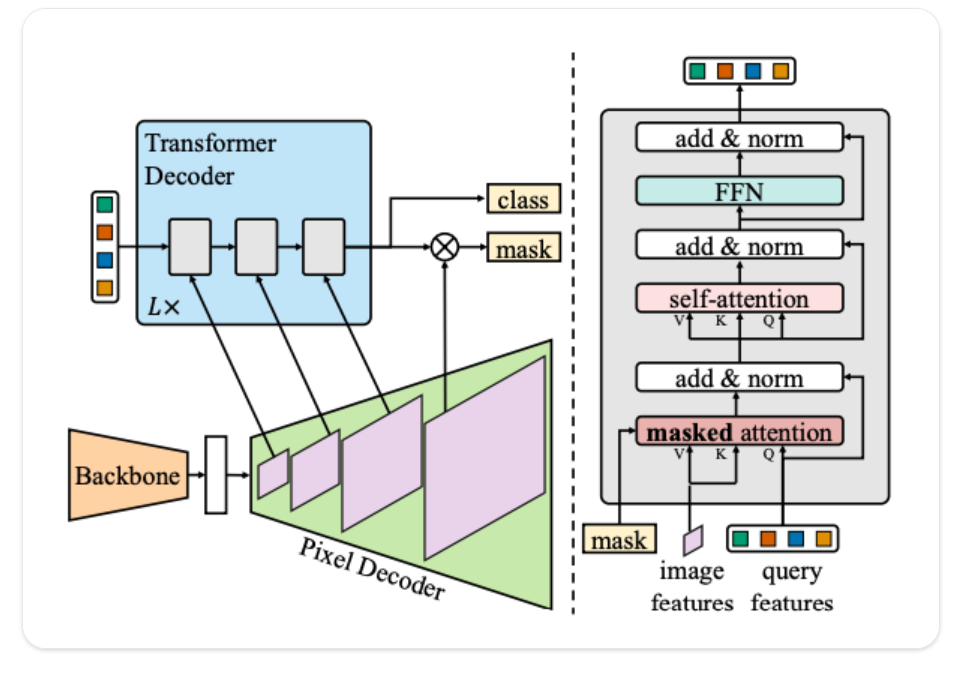

There are three main components to Mask2Former:

    A Swin backbone accepts an image and creates a low-resolution image feature map from 3 consecutive 3x3 convolutions.

    The feature map is passed to a pixel decoder which gradually upsamples the low-resolution features into high-resolution per-pixel embeddings. The pixel decoder actually generates multi-scale features (contains both low- and high-resolution features) with resolutions 1/32, 1/16, and 1/8th of the original image.

    Each of these feature maps of differing scales is fed successively to one Transformer decoder layer at a time in order to capture small objects from the high-resolution features. The key to Mask2Former is the masked attention mechanism in the decoder. Unlike cross-attention which can attend to the entire image, masked attention only focuses on a certain area of the image. This is faster and leads to better performance because the local features of an image are enough for the model to learn from.

    Like DETR, Mask2Former also uses learned object queries and combines them with the image features from the pixel decoder to make a set prediction (class label, mask prediction). The decoder hidden states are passed into a linear layer and transformed into logits over the class labels. The cross-entropy loss is calculated between the logits and class label to find the most likely one.

    The mask predictions are generated by combining the pixel-embeddings with the final decoder hidden states. The sigmoid cross-entropy and dice loss is calculated between the logits and the ground truth mask to find the most likely mask.

Ready to try your hand at object detection? Check out our complete image segmentation guide to learn how to finetune SegFormer and use it for inference!
Depth estimation

GLPN, Global-Local Path Network, is a Transformer for depth estimation that combines a SegFormer encoder with a lightweight decoder.

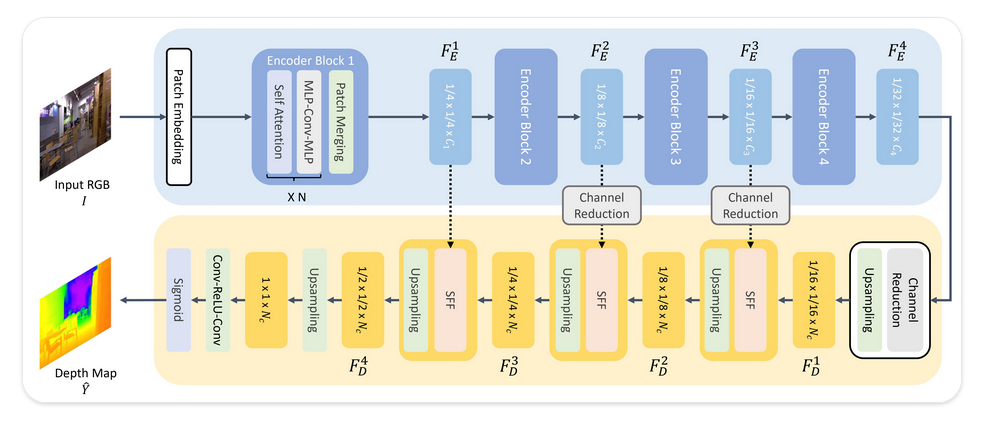

Like ViT, an image is split into a sequence of patches, except these image patches are smaller. This is better for dense prediction tasks like segmentation or depth estimation. The image patches are transformed into patch embeddings (see the image classification section for more details about how patch embeddings are created), which are fed to the encoder.

The encoder accepts the patch embeddings, and passes them through several encoder blocks. Each block consists of attention and Mix-FFN layers. The purpose of the latter is to provide positional information. At the end of each encoder block is a patch merging layer for creating hierarchical representations. The features of each group of neighboring patches are concatenated, and a linear layer is applied to the concatenated features to reduce the number of patches to a resolution of 1/4. This becomes the input to the next encoder block, where this whole process is repeated until you have image features with resolutions of 1/8, 1/16, and 1/32.

A lightweight decoder takes the last feature map (1/32 scale) from the encoder and upsamples it to 1/16 scale. From here, the feature is passed into a Selective Feature Fusion (SFF) module, which selects and combines local and global features from an attention map for each feature and then upsamples it to 1/8th. This process is repeated until the decoded features are the same size as the original image. The output is passed through two convolution layers and then a sigmoid activation is applied to predict the depth of each pixel.

Natural language processing

The Transformer was initially designed for machine translation, and since then, it has practically become the default architecture for solving all NLP tasks. Some tasks lend themselves to the Transformer’s encoder structure, while others are better suited for the decoder. Still, other tasks make use of both the Transformer’s encoder-decoder structure.
Text classification

BERT is an encoder-only model and is the first model to effectively implement deep bidirectionality to learn richer representations of the text by attending to words on both sides.

BERT uses WordPiece tokenization to generate a token embedding of the text. To tell the difference between a single sentence and a pair of sentences, a special [SEP] token is added to differentiate them. A special [CLS] token is added to the beginning of every sequence of text. The final output with the [CLS] token is used as the input to the classification head for classification tasks. BERT also adds a segment embedding to denote whether a token belongs to the first or second sentence in a pair of sentences.

BERT is pretrained with two objectives: masked language modeling and next-sentence prediction. In masked language modeling, some percentage of the input tokens are randomly masked, and the model needs to predict these. This solves the issue of bidirectionality, where the model could cheat and see all the words and “predict” the next word. The final hidden states of the predicted mask tokens are passed to a feedforward network with a softmax over the vocabulary to predict the masked word.

The second pretraining object is next-sentence prediction. The model must predict whether sentence B follows sentence A. Half of the time sentence B is the next sentence, and the other half of the time, sentence B is a random sentence. The prediction, whether it is the next sentence or not, is passed to a feedforward network with a softmax over the two classes (IsNext and NotNext).

The input embeddings are passed through multiple encoder layers to output some final hidden states.

To use the pretrained model for text classification, add a sequence classification head on top of the base BERT model. The sequence classification head is a linear layer that accepts the final hidden states and performs a linear transformation to convert them into logits. The cross-entropy loss is calculated between the logits and target to find the most likely label.

Ready to try your hand at text classification? Check out our complete text classification guide to learn how to finetune DistilBERT and use it for inference!

 Token classification

To use BERT for token classification tasks like named entity recognition (NER), add a token classification head on top of the base BERT model. The token classification head is a linear layer that accepts the final hidden states and performs a linear transformation to convert them into logits. The cross-entropy loss is calculated between the logits and each token to find the most likely label.

Ready to try your hand at token classification? Check out our complete token classification guide to learn how to finetune DistilBERT and use it for inference!

Question answering

To use BERT for question answering, add a span classification head on top of the base BERT model. This linear layer accepts the final hidden states and performs a linear transformation to compute the span start and end logits corresponding to the answer. The cross-entropy loss is calculated between the logits and the label position to find the most likely span of text corresponding to the answer.

Ready to try your hand at question answering? Check out our complete question answering guide to learn how to finetune DistilBERT and use it for inference!

💡 Notice how easy it is to use BERT for different tasks once it’s been pretrained. You only need to add a specific head to the pretrained model to manipulate the hidden states into your desired output!

Text generation

GPT-2 is a decoder-only model pretrained on a large amount of text. It can generate convincing (though not always true!) text given a prompt and complete other NLP tasks like question answering despite not being explicitly trained to.

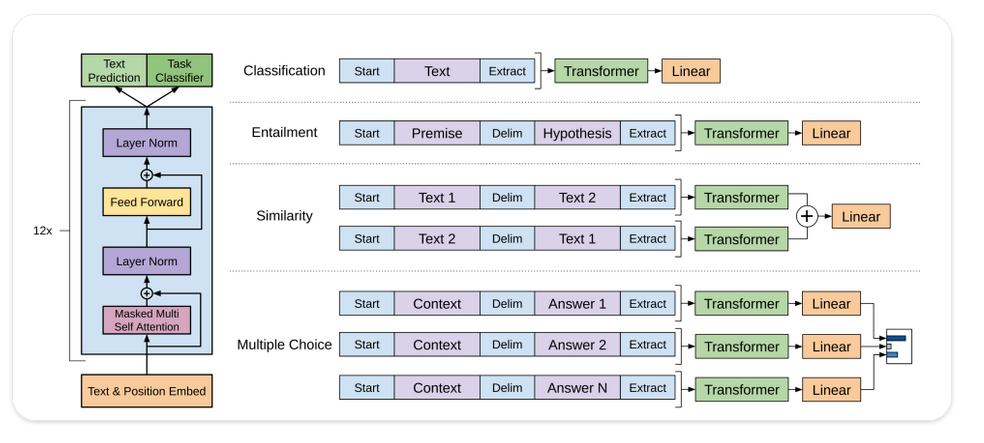



GPT-2 uses byte pair encoding (BPE) to tokenize words and generate a token embedding. Positional encodings are added to the token embeddings to indicate the position of each token in the sequence. The input embeddings are passed through multiple decoder blocks to output some final hidden state. Within each decoder block, GPT-2 uses a masked self-attention layer which means GPT-2 can’t attend to future tokens. It is only allowed to attend to tokens on the left. This is different from BERT’s mask token because, in masked self-attention, an attention mask is used to set the score to 0 for future tokens.

The output from the decoder is passed to a language modeling head, which performs a linear transformation to convert the hidden states into logits. The label is the next token in the sequence, which are created by shifting the logits to the right by one. The cross-entropy loss is calculated between the shifted logits and the labels to output the next most likely token.

GPT-2’s pretraining objective is based entirely on causal language modeling, predicting the next word in a sequence. This makes GPT-2 especially good at tasks that involve generating text.

Ready to try your hand at text generation? Check out our complete causal language modeling guide to learn how to finetune DistilGPT-2 and use it for inference!

For more information about text generation, check out the text generation strategies guide!

 Summarization

Encoder-decoder models like BART and T5 are designed for the sequence-to-sequence pattern of a summarization task. We’ll explain how BART works in this section, and then you can try finetuning T5 at the end

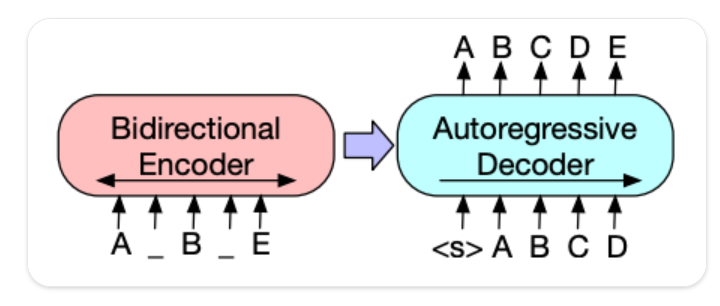

BART’s encoder architecture is very similar to BERT and accepts a token and positional embedding of the text. BART is pretrained by corrupting the input and then reconstructing it with the decoder. Unlike other encoders with specific corruption strategies, BART can apply any type of corruption. The text infilling corruption strategy works the best though. In text infilling, a number of text spans are replaced with a single mask token. This is important because the model has to predict the masked tokens, and it teaches the model to predict the number of missing tokens. The input embeddings and masked spans are passed through the encoder to output some final hidden states, but unlike BERT, BART doesn’t add a final feedforward network at the end to predict a word.

The encoder’s output is passed to the decoder, which must predict the masked tokens and any uncorrupted tokens from the encoder’s output. This gives additional context to help the decoder restore the original text. The output from the decoder is passed to a language modeling head, which performs a linear transformation to convert the hidden states into logits. The cross-entropy loss is calculated between the logits and the label, which is just the token shifted to the right.

Ready to try your hand at summarization? Check out our complete summarization guide to learn how to finetune T5 and use it for inference!

For more information about text generation, check out the text generation strategies guide!
Translation

Translation is another example of a sequence-to-sequence task, which means you can use an encoder-decoder model like BART or T5 to do it. We’ll explain how BART works in this section, and then you can try finetuning T5 at the end.

BART adapts to translation by adding a separate randomly initialized encoder to map a source language to an input that can be decoded into the target language. This new encoder’s embeddings are passed to the pretrained encoder instead of the original word embeddings. The source encoder is trained by updating the source encoder, positional embeddings, and input embeddings with the cross-entropy loss from the model output. The model parameters are frozen in this first step, and all the model parameters are trained together in the second step.

BART has since been followed up by a multilingual version, mBART, intended for translation and pretrained on many different languages.

Ready to try your hand at translation? Check out our complete translation guide to learn how to finetune T5 and use it for inference!

For more information about text generation, check out the text generation strategies guide!